In [ ]:
# Bari - Desafio de Estágio
# Mateus Luiz Bailo - Email: mateus_bailo@hotmail.com

# -------------------------------
# 1. Carregamento de Bibliotecas
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sqlalchemy import create_engine
from dotenv import load_dotenv


In [24]:
# --------------------------
# 2. Conexão com o Banco de Dados MySQL
# --------------------------

load_dotenv()

usuario = os.getenv("DB_USER")
senha = os.getenv("DB_PASSWORD").replace("@", "%40")
host = os.getenv("DB_HOST")
porta = os.getenv("DB_PORT")
banco = os.getenv("DB_NAME")



conexao = create_engine(f"mysql+mysqlconnector://{usuario}:{senha}@{host}:{porta}/{banco}")

In [25]:
# --------------------------
# 3. Consulta SQL: Carregamento dos Dados
# --------------------------

query = """
    SELECT id_cliente as IdCliente
          ,idade AS Idade
          ,renda_mensal as RendaMensal
          ,score_credito as ScoreCredito
          ,valor_imovel as ValorImovel
          ,prazo_contrato_meses as ContratoMeses
          ,valor_financiado as ValorFinanciado
          ,inadimplente as Inadimplente
    FROM clientes_credito 
"""

df_sql = pd.read_sql(query, conexao)
print(df_sql.head())


   IdCliente  Idade  RendaMensal  ScoreCredito  ValorImovel  ContratoMeses  \
0          1     59     13921.40           548    463771.95            360   
1          2     49      6939.90           825    444990.02            360   
2          3     35      7116.43           761    489861.78            300   
3          4     63      2933.34           312    263163.69            300   
4          5     28      9427.98           683    419948.53            120   

   ValorFinanciado  Inadimplente  
0        255471.75             0  
1        194613.60             0  
2        305831.89             0  
3        173892.50             1  
4        307163.49             0  


In [26]:
# --------------------------
# 4. Análise Exploratória
# --------------------------
print("-------------Informações sobre as variaveis-------------")
print(df_sql.info())
print("-------------Informações sobre a tabela-------------")
print(df_sql.describe())
print("-------------Quantidade de Null's-------------")
print(df_sql.isnull().sum())

-------------Informações sobre as variaveis-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IdCliente        2000 non-null   int64  
 1   Idade            2000 non-null   int64  
 2   RendaMensal      2000 non-null   float64
 3   ScoreCredito     2000 non-null   int64  
 4   ValorImovel      2000 non-null   float64
 5   ContratoMeses    2000 non-null   int64  
 6   ValorFinanciado  2000 non-null   float64
 7   Inadimplente     2000 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 125.1 KB
None
-------------Informações sobre a tabela-------------
         IdCliente        Idade   RendaMensal  ScoreCredito    ValorImovel  \
count  2000.000000  2000.000000   2000.000000   2000.000000    2000.000000   
mean   1000.500000    45.235000   8106.486620    575.658500  395943.821845   
std     577.494589    14.044942  

In [27]:
# --------------------------
# 4. Análise Exploratória
# --------------------------

query_clientes_risco = """
SELECT id_cliente as IdCliente
      ,idade as Idade
      ,renda_mensal as RendaMensal
      ,score_credito as ScoreCredito
      ,inadimplente as Inadimplente
FROM clientes_credito
WHERE score_credito < 500 AND inadimplente = 1
"""

df_risco = pd.read_sql(query_clientes_risco, conexao)
print("Clientes com alto risco:")
print(df_risco) # 145 Clientes de Risco

Clientes com alto risco:
     IdCliente  Idade  RendaMensal  ScoreCredito  Inadimplente
0            4     63      2933.34           312             1
1           23     22      8071.49           463             1
2           34     36      4592.40           493             1
3           56     28      3934.46           303             1
4           57     67     12291.91           392             1
..         ...    ...          ...           ...           ...
140       1920     31      9108.18           384             1
141       1941     30      3993.31           448             1
142       1946     53      8549.46           473             1
143       1979     28      5039.24           372             1
144       2000     33     10726.87           381             1

[145 rows x 5 columns]


In [28]:
# --------------------------
# 5. Implementação da Ideia SLO (Service Level Offer)
# --------------------------

# Função para classificar clientes em níveis de SLO
def classificar_slo(row):
    if row["Inadimplente"] == 0:
        if row["ScoreCredito"] >= 700 and row["ValorImovel"] >= 500000:
            return "Ouro"
        elif 500 <= row["ScoreCredito"] < 700 and row["ValorImovel"] >= 300000:
            return "Prata"
        else:
            return "Bronze"
    else:
        return "Bronze"

# Aplicando ao DataFrame
df_sql["SLO"] = df_sql.apply(classificar_slo, axis=1)

# Contagem de clientes por nível SLO
print("Distribuição dos níveis SLO:")
print(df_sql["SLO"].value_counts())

# Aplica a SLO aos clientes de risco
df_risco["SLO"] = df_risco.apply(classificar_slo, axis=1)

# Distribuição dos SLOs entre clientes de risco
print("Distribuição de SLO entre clientes de alto risco:")
print(df_risco["SLO"].value_counts())

Distribuição dos níveis SLO:
SLO
Bronze    1396
Prata      530
Ouro        74
Name: count, dtype: int64
Distribuição de SLO entre clientes de alto risco:
SLO
Bronze    145
Name: count, dtype: int64


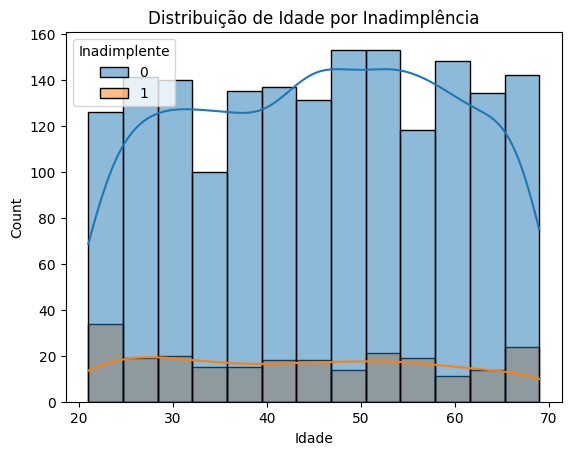

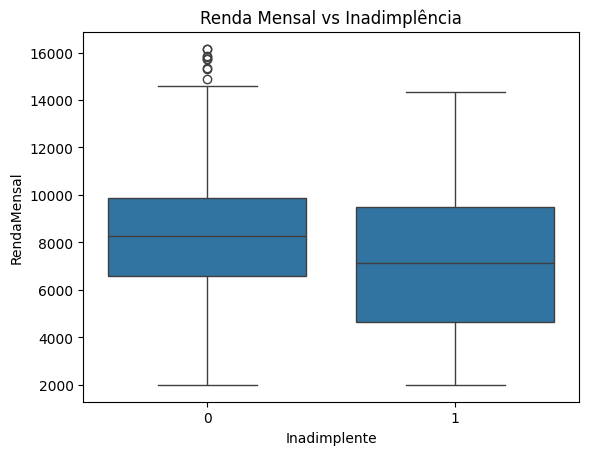

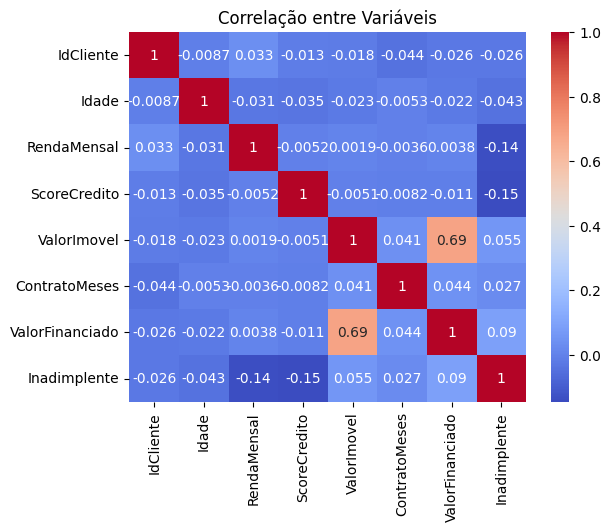

In [29]:
# --------------------------
# 6. Começando algumas visualizações
# --------------------------

# Visualizações gerais
sns.histplot(data=df_sql, x="Idade", hue="Inadimplente", kde=True)
plt.title("Distribuição de Idade por Inadimplência")
plt.show()

sns.boxplot(data=df_sql, x="Inadimplente", y="RendaMensal")
plt.title("Renda Mensal vs Inadimplência")
plt.show()

sns.heatmap(df_sql.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis")
plt.show()

In [30]:
# -----------------------------------
# 7. Pre-processamento dos Dados - Balanceamento dos Dados
# -----------------------------------
positivos = df_sql[df_sql['Inadimplente'] == 1]
negativos = df_sql[df_sql['Inadimplente'] == 0].sample(len(positivos), random_state=42)

df_balanceado = pd.concat([positivos, negativos]).sample(frac=1, random_state=42)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        42
           1       0.75      0.69      0.72        55

    accuracy                           0.69        97
   macro avg       0.69      0.69      0.69        97
weighted avg       0.70      0.69      0.69        97



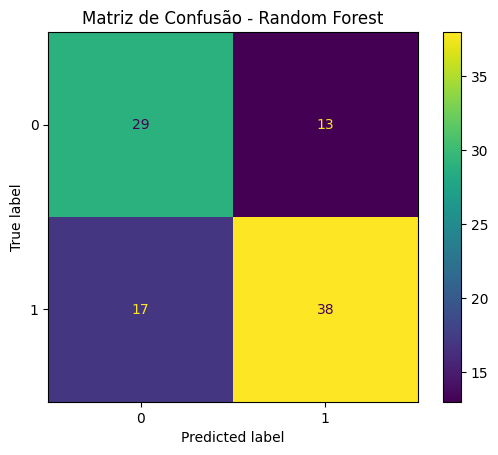

AUC-ROC Score: 0.6868


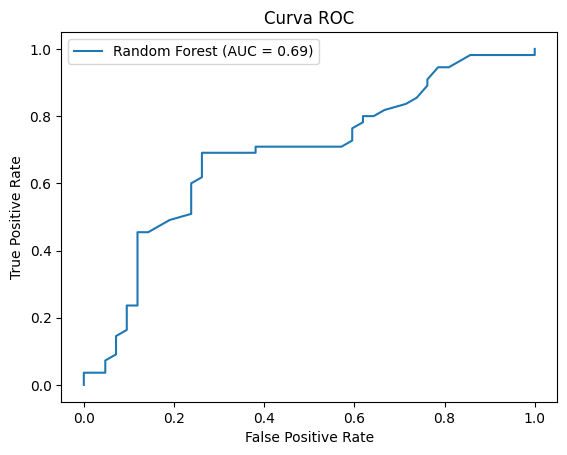

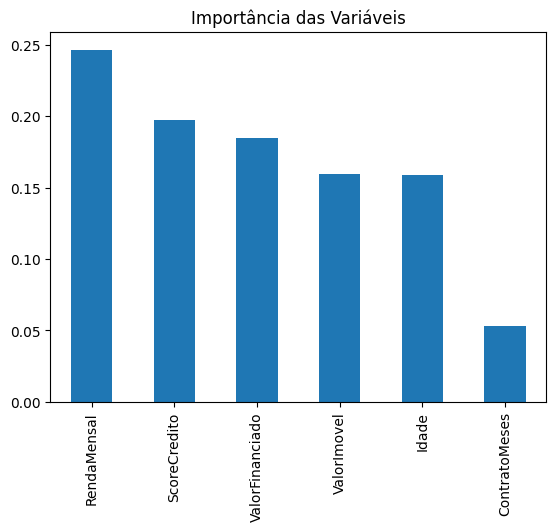

Top 5 variáveis mais importantes:
RendaMensal        0.246634
ScoreCredito       0.197689
ValorFinanciado    0.184764
ValorImovel        0.159188
Idade              0.158963
dtype: float64


In [ ]:
# -------------------------------
# 8. Treinamento e Avaliação do Modelo Preditivo
# -------------------------------
X = df_balanceado.drop(columns=["IdCliente", "Inadimplente", "SLO"])
y = df_balanceado["Inadimplente"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Exibe matriz de confusão
display = ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# Avaliação com AUC-ROC
'''
Intervalo AUC-ROC | Interpretação
0.5 |     |Aleatório (ruim)
0.6 | 0.7 | Fraco / aceitável
0.7 | 0.8 | Bom
0.8 | 0.9 | Muito bom
    > 0.9 | Excelente 
'''
y_prob = modelo.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Importância das variáveis
importances = pd.Series(modelo.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', title='Importância das Variáveis')
plt.show()

print("Top 5 variáveis mais importantes:")
print(importances.sort_values(ascending=False).head())

# Observação: O modelo identificou que Score de Crédito, Valor do Imóvel e Renda Mensal
# são as variáveis mais relevantes para prever inadimplência.


Cruzamento entre SLO e Predição:
Previsto Inadimplente    0    1
SLO                            
Bronze                 821  575
Ouro                    65    9
Prata                  431   99


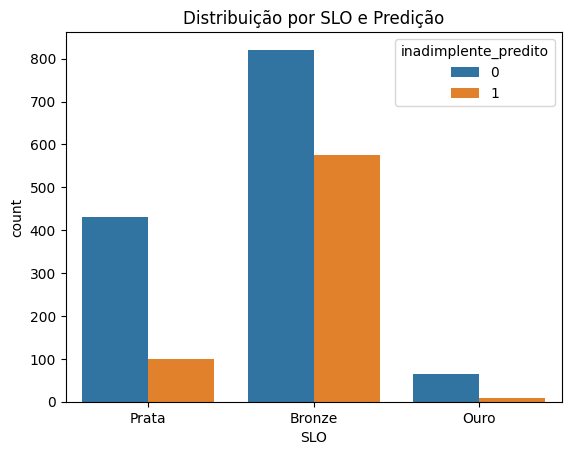

In [32]:
# ------------------------------
# 7. Cruzamento SLO com Predição
# ------------------------------

X_todos = df_sql.drop(columns=["IdCliente", "Inadimplente", "SLO"])
df_sql["inadimplente_predito"] = modelo.predict(X_todos)

print("\nCruzamento entre SLO e Predição:")
print(pd.crosstab(df_sql["SLO"], df_sql["inadimplente_predito"], rownames=["SLO"], colnames=["Previsto Inadimplente"]))

sns.countplot(data=df_sql, x="SLO", hue="inadimplente_predito")
plt.title("Distribuição por SLO e Predição")
plt.show()


In [34]:
# -----------------------------------
# 9. Exportortações
# -----------------------------------

# Salvar os DataFrames em CSV para importação no Power BI
df_sql.to_csv('df_clientes_preditos.csv', index=False)


print("Arquivos exportados para Power BI:")
print("- clientes_preditos.csv")



Arquivos exportados para Power BI:
- clientes_preditos.csv
